# Importa as bibliotecas e as funções que serão necessárias para fazer os mapas mentais a partir de pdfs.

In [16]:
import time
import google.generativeai as genai
import os
import time
import datetime
from IPython.display import Image, display

### DEFINE FUNÇÃO QUE VERIFICA SE HÁ ARQUIVO ENVIADO POR UPLOAD À NUVEM GENAI
def verifica_arquivos_nuvem_genai():
    global varArquivoNaNuvem 
    lista_arquivos_nuvem = []
    for file in genai.list_files():
        lista_arquivos_nuvem.append(file)

    if not lista_arquivos_nuvem:
        print('Não há arquivos na nuvem Genai.')
        varArquivoNaNuvem = False
    else:
        print('Há arquivos na nuvem Genai.')
        print(genai.list_files())
        varArquivoNaNuvem = True

### DEFINE FUNÇÃO QUE VAI SOLICITAR A RESPOSTA DO GEMINI E FORMATÁ-LA EM PUML MINDMAP
def roda_API():
    global str_puml
    global lines
    response = model.generate_content([file, texto_prompt])
    # Procura garantir que a resposta do Gemini fique de fato no formato .puml:
    lines = response.text.split('\n')
    
    # Verificar se a primeira linha não começa com '*' nem '@startmindmap'
    if not lines[0].startswith('*') and not lines[0] == '@startmindmap':
        # Remover a primeira linha e adicionar '@startmindmap' na primeira linha
        lines = ['@startmindmap'] + lines[1:]
    
    # Verificar se a primeira linha começa com '*' 
    if lines[0].startswith('*'):
        # Acrescentar uma linha no início com '@startmindmap'
        lines = ['@startmindmap'] + lines
    
    # Verificar se a última linha não começa com '*' nem '@endmindmap'
    if not lines[-1].startswith('*') and not lines[-1] == '@endmindmap':
        # Remover a última linha e adicionar '@startmindmap' na última linha
        lines = lines[0:-1] + ['@endmindmap']
    
    # Verificar se a última linha começa com '*' 
    if lines[-1].startswith('*'):
        # Acrescentar uma linha no fim com '@endmindmap'
        lines = lines + ['@endmindmap']
    
    lines[1:-1] = [line for line in lines[1:-1] if line.startswith('*')]
            
    # Juntar as linhas novamente em uma string
    str_puml = '\n'.join(lines)
    # Confere se respeitou os criterios
    confere_criterio()

### DEFINE FUNÇÃO QUE VAI CONFERIR SE O PUML MINDMAP GERADO PELO GEMINI CHEGOU NO 4º NÍVEL, QUE É UMA LINHA INICIADA POR "**** "
def confere_criterio():
    global var_fim
    # Inicialização da variável contador_erro_criterio
    if 'contador_erro_criterio' not in globals():
        global contador_erro_criterio
        contador_erro_criterio = 0
    var_fim = False
    for line in lines:
        if line.startswith("**** "):
            var_fim = True
    if var_fim==True:
        gera_mapa_mental()
        contador_erro_criterio = 0
    else:
        print("O .puml gerado pelo Gemini não atende os critérios. Suspensão iniciada por 10 segundos...")
        time.sleep(10)
        print("10 segundos se passaram. Execução retomada. Vamos tentar gerar um mapa mental com o Gemini novamente.")
        contador_erro_criterio += 1
        if contador_erro_criterio < 5:
            roda_API()
        else:
            contador_erro_criterio = 0
            print(f"Não foi possível gerar mapa mental para o arquivo {file}. O Gemini gerou 5 vezes um .puml que não atendeu o critério de ter no mínimo 4 níveis.")

### DEFINE FUNÇÃO QUE VAI GERAR O MAPA MENTAL
def gera_mapa_mental():
    # Gera o mapa mental em formato .png
    print("Tentativa de gerar o mapa iniciada.")

    # Gerar a data e hora no formato desejado
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Nome do arquivo .puml com a data e hora
    path_puml = f"puml\\{timestamp}_mapa_mental_{file.display_name}.puml"
    
    # Gerar o nome do arquivo PNG de saída
    path_png = path_puml[:-4]+"png"
    
    # Criar o arquivo PlantUML com o mapa mental
    with open(path_puml, "w") as f:
        f.write(str_puml)
    
    # Passo 2: Executar o PlantUML localmente para gerar a imagem
    plantuml_jar_path = "C:\\Users\\diego\\anaconda3\\plantuml\\plantuml-1.2024.7.jar"
    #command = f"java -jar \"{plantuml_jar_path}\" \"{path_puml}\""
    command = f"java -Dfile.encoding=UTF-8 -jar \"{plantuml_jar_path}\" \"{path_puml}\""
    
    # Executar o comando e verificar o retorno
    exit_code = os.system(command)
    
    if exit_code == 0:
        print("Imagem gerada com sucesso!")
    else:
        print("Houve um erro ao gerar a imagem.")
    
    # Passo 3: Exibir a imagem no Jupyter se ela foi gerada corretamente
    if os.path.exists(path_png):
        display(Image(path_png))
        contador_erros=0
    else:
        print("Imagem não encontrada. Verifique se o PlantUML converteu corretamente o arquivo .puml em .png.")
    # Suspender a execução por 10 segundos
    print("Suspensão de 10 segundos iniciada...")
    time.sleep(10)

# Inicializa do modelo Genai e faz upload dos pdfs para a nuvem Genai
Rode esse código para que os pdfs que estão na sua máquina, na pasta "pdf" deste projeto, sejam enviados para a nuvem Genai do Google.

In [17]:
with open('GOOGLE_API_KEY.txt', 'r', encoding='utf-8') as file: # Abre o arquivo 'GOOGLE_API_KEY.txt' no modo de leitura (read)
    GOOGLE_API_KEY = file.read() # salva o conteúdo do arquivo na variável GOOGLE_API_KEY

#### CONFIGURA O LARGE LANGUAGE MODEL (LLM) GEMINI ####
genai.configure(api_key=GOOGLE_API_KEY) # Configura o genai com a GOOGLE_API_KEY
model = genai.GenerativeModel(model_name="gemini-1.5-flash") # Define o modelo Gemini.

verifica_arquivos_nuvem_genai() # Verifica se há arquivos na nuvem Genai

#### REMOVE TODOS OS ARQUIVOS QUE FORAM ENVIADOS POR UPLOAD À NUVEM GENAI (google.generativeai)  ####
if varArquivoNaNuvem:
    for file in genai.list_files(): # Inicia o loop na lista de arquivos da nuvem genai
        genai.delete_file(file.name) # Deletar arquivo da nuvem genai
        print(f"O arquivo {file.display_name} foi removido da nuvem.")

verifica_arquivos_nuvem_genai() # Verifica se há arquivos na nuvem Genai

#### FAZ UPLOAD DOS ARQUIVOS PARA A NUVEM GENAI (google.generativeai) ####
pasta_pdf = "pdf" # Define o diretório onde estão os arquivos PDF
arquivos = [os.path.join(pasta_pdf, pdf) for pdf in os.listdir(pasta_pdf)] # Lista todos os arquivos da pasta_pdf com caminho completo
arquivos.sort(key=os.path.getctime) # Ordena os arquivos pela data de criação
for path in arquivos: # Inicia o loop na lista dos caminhos completos dos arquivos
    nome_pdf = os.path.basename(path) # obtém o nome do arquivo
    if nome_pdf.endswith('.pdf'):  # Verifica se o arquivo é um PDF      
        file = genai.upload_file(path=path, display_name=nome_pdf)  # Faz upload do arquivo   
        print(f"Uploaded file '{file.display_name}' as: {file.uri}")
        time.sleep(1) # espera 1 segundo para iterar novamente, para facilitar a visualização de diferença de datas de criação dos arquivos na nuvem
uploaded_files = list(genai.list_files())  # cria a lista de uploads utilizando o generator genai.list_files()
sorted_files = sorted(uploaded_files, key=lambda file: file.create_time) # Ordena a lista de uploads pelo atributo 'create_time'
for file in sorted_files: # Exibe a lista ordenada de uploads
    print(f"{file.display_name} - {file.create_time}")

Há arquivos na nuvem Genai.
<generator object list_files at 0x000001D41F6BB6F0>
O arquivo Tecnologia_da_informação.pdf foi removido da nuvem.
O arquivo Programação_de_computadores.pdf foi removido da nuvem.
Não há arquivos na nuvem Genai.
Uploaded file 'Programação_de_computadores.pdf' as: https://generativelanguage.googleapis.com/v1beta/files/x58ssv6mz2db
Uploaded file 'Tecnologia_da_informação.pdf' as: https://generativelanguage.googleapis.com/v1beta/files/jw0o9xrbtdx8
Programação_de_computadores.pdf - 2024-11-26 00:53:38.511576+00:00
Tecnologia_da_informação.pdf - 2024-11-26 00:53:42.702431+00:00


# Define o prompt que será enviado com cada pdf para o Gemini e executa todas as funções necessárias para gerar os mapas mentais em formato .png

Tentativa de gerar o mapa iniciada.
Imagem gerada com sucesso!


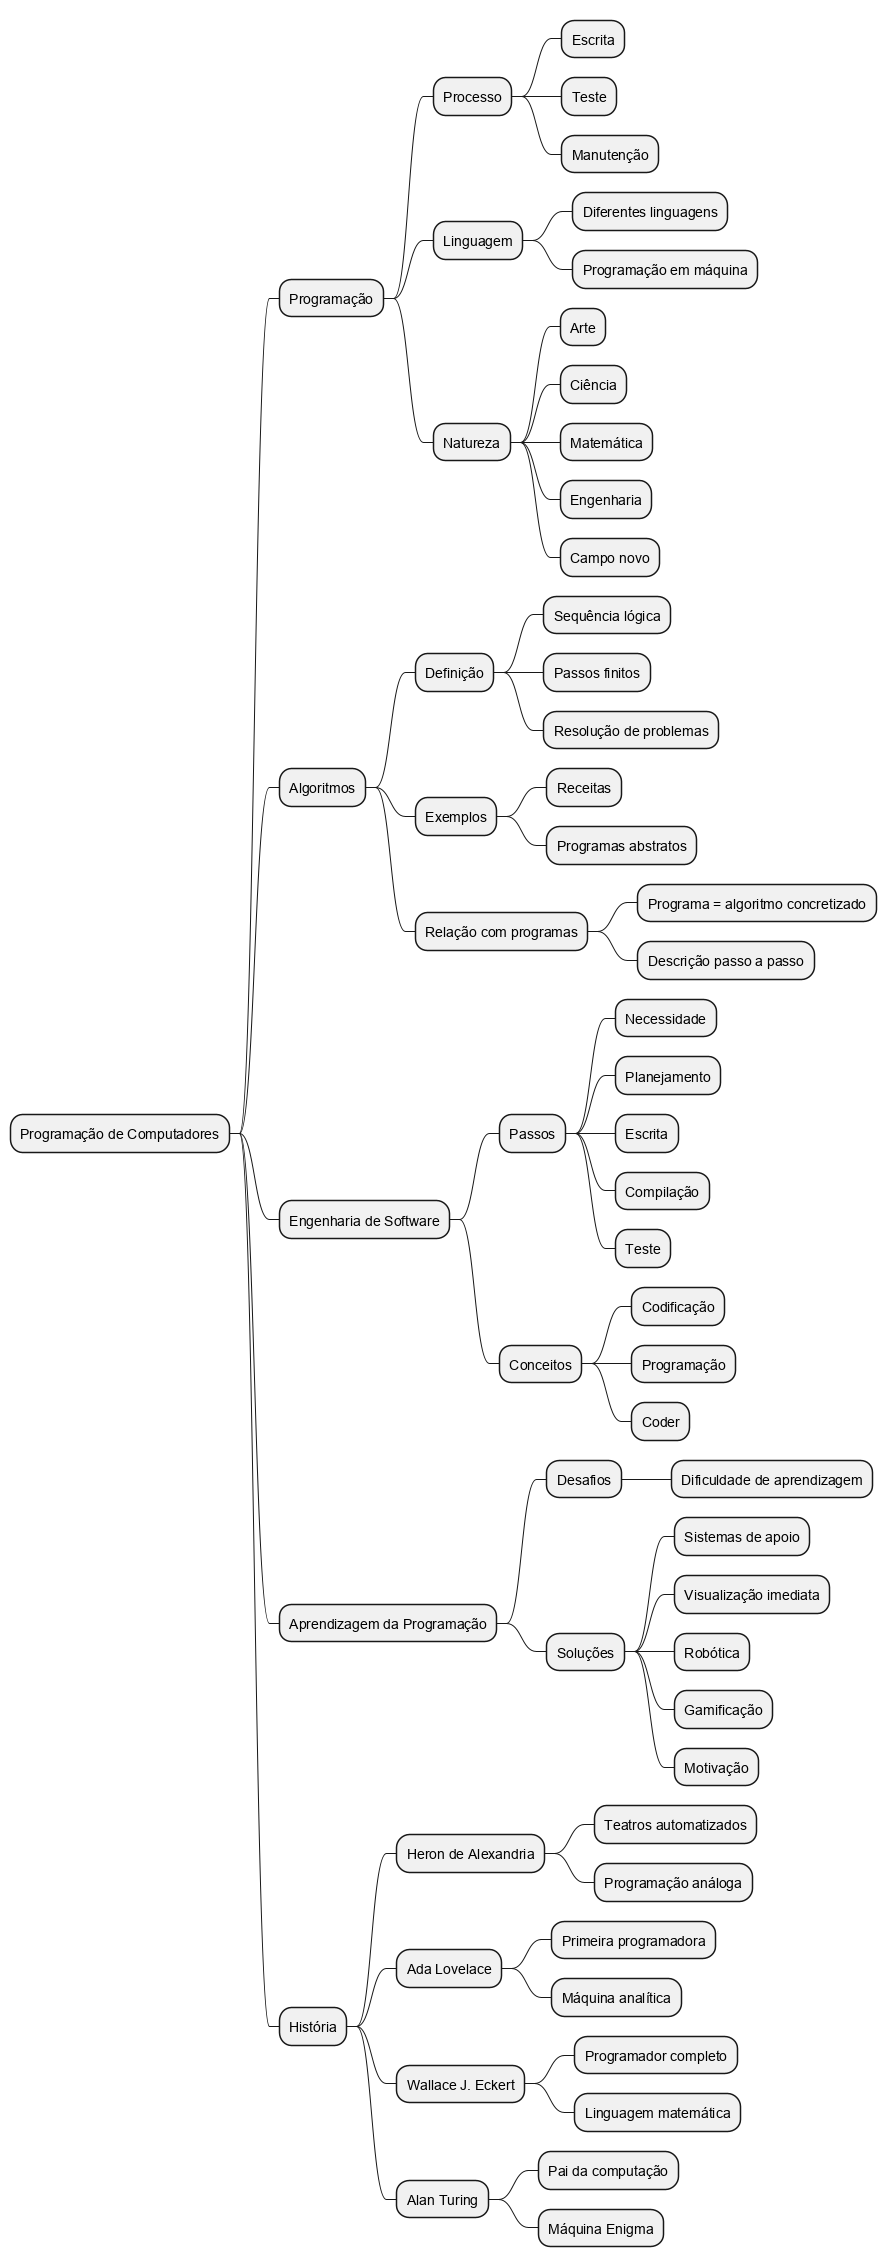

Suspensão de 10 segundos iniciada...
Tentativa de gerar o mapa iniciada.
Imagem gerada com sucesso!


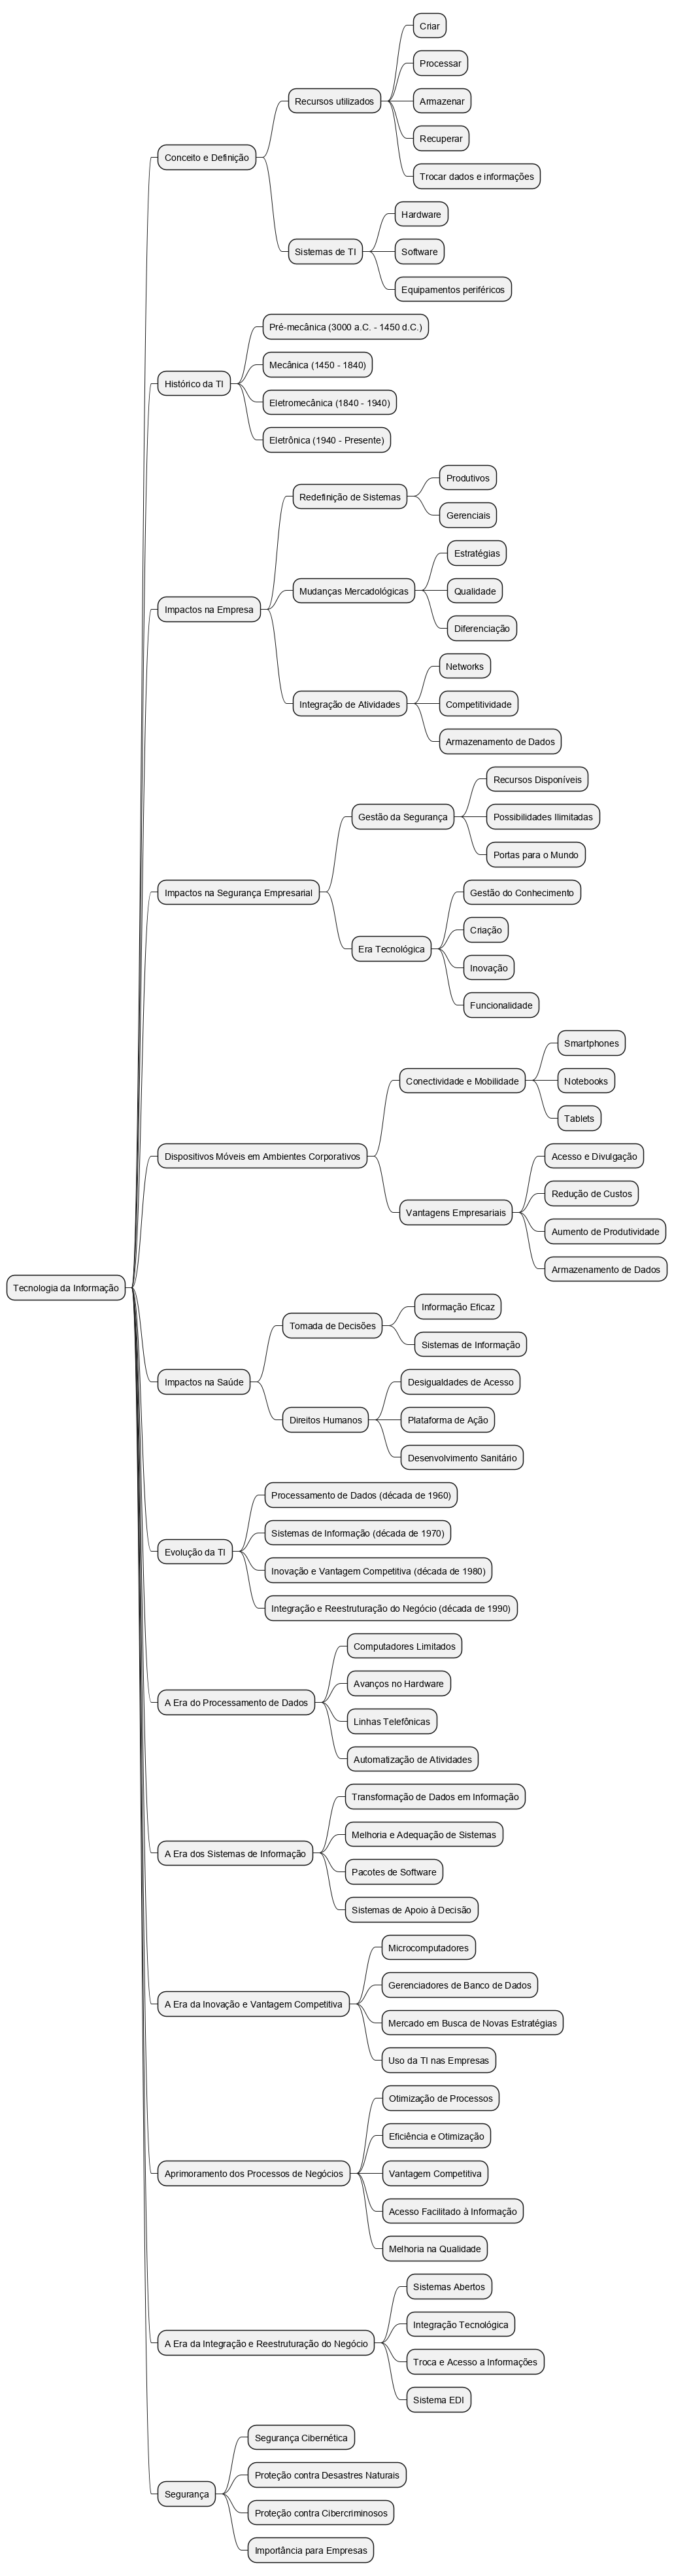

Suspensão de 10 segundos iniciada...
Script finalizado! Todos os arquivos da pasta 'pdf' foram varridos para gerar mapas mentais.


In [18]:
#### ENVIA OS PROMPTS PARA O GEMINI E GERA OS MAPAS MENTAIS ####
for file in sorted_files:
    global contador_erros
    contador_erros = 0
    lista_erros = []
    try:
        # Código que pode gerar um erro
        texto_prompt = '''
        Por favor, faça um mapa mental desse PDF em formato .puml de tópicos e subtópicos para ser usado no plantuml, sem indentações.
        O primeiro nível deve iniciar com '* '. O segundo nível deve iniciar com '** ', e assim sucessivamente.
        Não utilize '-' na parte inicial de cada tópico.
        O mapa deve ter pelo menos 4 níveis.
        No primeiro nível, são permitidas de 1 até 10 palavras.
        No segundo nível, são permitidas de 1 até 10 palavras.
        No terceiro nível, são permitidas de 1 até 10 palavras.
        No quarto nível, são permitidas de 1 até 10 palavras.
        Não inclua considerações finais, materiais complementares, referências bibliográficas ou outros tópicos que não explicitem conceitos.
        '''
        var_fim = False
        while var_fim == False:
            roda_API()

    except Exception as e:
        contador_erros+=1
        # Tratamento do erro (pode ser um log ou print)
        print(f"Ocorreu um erro com o item {file.display_name}: {e}")
        if contador_erros < 5:
            roda_API()
        else:
            lista_erros.append(file.display_name)
        # Passa para a próxima iteração
        continue
print("Script finalizado! Todos os arquivos da pasta 'pdf' foram varridos para gerar mapas mentais.")